### VGG-19

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
from torch.utils.data import random_split

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
# Training hyperparameters
num_epochs = 60
batch_size = 128
learning_rate = 0.001
weight_decay = 1e-4

# CIFAR-100 has 100 classes
num_classes = 100

# Path to save model
model_save_path = './vgg19_cifar100.pth'

In [22]:
# CIFAR-100 normalization statistics
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

# Define transforms for training and testing
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='./data', train=True, 
                                  download=True, transform=train_transform)
test_dataset = datasets.CIFAR100(root='./data', train=False,
                                download=True, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=4, pin_memory=True)

# Get class names
class_names = train_dataset.classes
print(f"Dataset loaded: {len(train_dataset)} training samples, {len(test_dataset)} test samples")

Files already downloaded and verified
Files already downloaded and verified
Dataset loaded: 50000 training samples, 10000 test samples


In [23]:
def get_vgg19_model(num_classes=100):
    # Option 1: Start from scratch (no pre-trained weights)
    model = models.vgg19_bn(weights=None)
    
    # Adjust for CIFAR-100
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(512, 512),
        nn.ReLU(True),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    
    # Use adaptive pooling to ensure correct dimensions
    model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    
    return model

# Initialize the model
model = get_vgg19_model(num_classes)
model = model.to(device)


# Display model summary
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [24]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, 
                     momentum=0.9, weight_decay=5e-4)
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [25]:

# Set aside 10% of training data for validation
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size

# Randomly split the dataset
train_subset, val_subset = random_split(
    train_dataset, [train_size, val_size], 
    generator=torch.Generator().manual_seed(42)
)

# Create data loaders for the subsets
train_loader = DataLoader(train_subset, batch_size=batch_size, 
                          shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size,
                        shuffle=False, num_workers=4, pin_memory=True)

dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

print(f"Training set: {len(train_subset)} samples")
print(f"Validation set: {len(val_subset)} samples")
print(f"Test set: {len(test_dataset)} samples")

Training set: 45000 samples
Validation set: 5000 samples
Test set: 10000 samples


In [26]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            loader = dataloaders['train'] if phase == 'train' else dataloaders['val']
            dataset_size = len(dataloaders['train'].dataset) if phase == 'train' else len(dataloaders['val'].dataset)
            
            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Record history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
                # Adjust learning rate based on validation loss
                scheduler.step(epoch_loss)
                
                # Deep copy the model if it's the best
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [27]:
# Train the model
model, history = train_model(
    model, 
    dataloaders, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=num_epochs
)

# Save the trained model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Epoch 1/60
----------
train Loss: 4.5945 Acc: 0.0192
val Loss: 4.4261 Acc: 0.0388

Epoch 2/60
----------
train Loss: 4.4075 Acc: 0.0344
val Loss: 4.1931 Acc: 0.0626

Epoch 3/60
----------
train Loss: 4.1977 Acc: 0.0521
val Loss: 3.9775 Acc: 0.0904

Epoch 4/60
----------
train Loss: 4.0324 Acc: 0.0724
val Loss: 3.8128 Acc: 0.1028

Epoch 5/60
----------
train Loss: 3.8817 Acc: 0.0904
val Loss: 3.6564 Acc: 0.1284

Epoch 6/60
----------
train Loss: 3.7550 Acc: 0.1082
val Loss: 3.5651 Acc: 0.1400

Epoch 7/60
----------
train Loss: 3.6487 Acc: 0.1240
val Loss: 3.4620 Acc: 0.1618

Epoch 8/60
----------
train Loss: 3.5496 Acc: 0.1395
val Loss: 3.3703 Acc: 0.1818

Epoch 9/60
----------
train Loss: 3.4538 Acc: 0.1557
val Loss: 3.3004 Acc: 0.1922

Epoch 10/60
----------
train Loss: 3.3537 Acc: 0.1741
val Loss: 3.1852 Acc: 0.2112

Epoch 11/60
----------
train Loss: 3.2639 Acc: 0.1932
val Loss: 3.0805 Acc: 0.2368

Epoch 12/60
----------
train Loss: 3.1790 Acc: 0.2072
val Loss: 3.0355 Acc: 0.2464

E

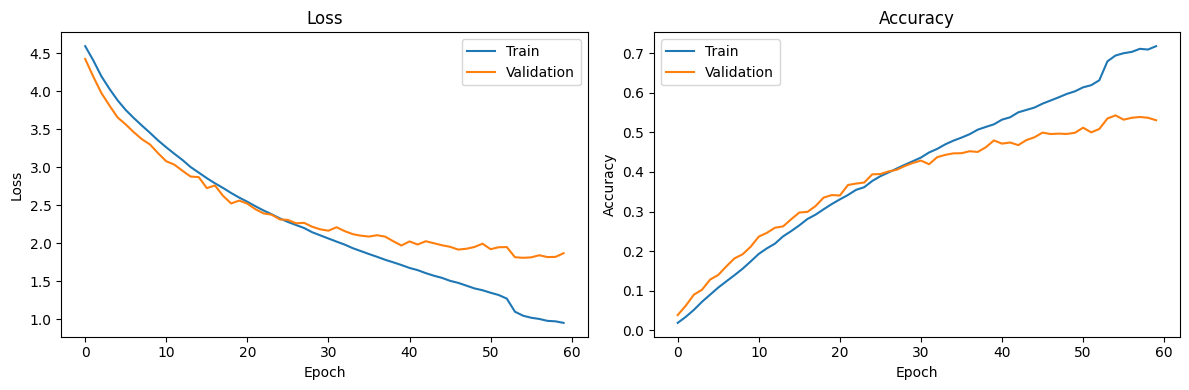

In [28]:
# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Collect all predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    dataset_size = len(dataloader.dataset)
    test_loss = running_loss / dataset_size
    test_acc = running_corrects.double() / dataset_size
    
    print(f'Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}')
    
    return test_loss, test_acc, all_preds, all_labels

# Evaluate on the test set
test_loss, test_acc, all_preds, all_labels = evaluate_model(model, test_loader, criterion)

Test Loss: 1.7306 Test Acc: 0.5601


In [30]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, output_dict=True)

# Create a DataFrame from the metrics
rows = []
for cls_str, vals in report.items():
    if cls_str.isdigit():
        i = int(cls_str)
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        rows.append({
            'class': i,
            'class_name': class_names[i] if i < len(class_names) else f"Class {i}",
            'TP': tp,
            'FP': fp,
            'FN': fn,
            'TN': tn,
            'Precision': vals['precision'],
            'Recall': vals['recall'],
            'F1-score': vals['f1-score']
        })

df_metrics = pd.DataFrame(rows).sort_values('class').reset_index(drop=True)
print(df_metrics.head(10))  # Show first 10 classes

# Overall Accuracy
overall_acc = np.trace(cm) / cm.sum()
print(f"\nOverall Test Accuracy: {overall_acc:.4f}")

   class     class_name  TP  FP  FN    TN  Precision  Recall  F1-score
0      0          apple  83  21  17  9879   0.798077    0.83  0.813725
1      1  aquarium_fish  72  34  28  9866   0.679245    0.72  0.699029
2      2           baby  38  56  62  9844   0.404255    0.38  0.391753
3      3           bear  32  77  68  9823   0.293578    0.32  0.306220
4      4         beaver  38  68  62  9832   0.358491    0.38  0.368932
5      5            bed  60  71  40  9829   0.458015    0.60  0.519481
6      6            bee  68  42  32  9858   0.618182    0.68  0.647619
7      7         beetle  55  42  45  9858   0.567010    0.55  0.558376
8      8        bicycle  71  33  29  9867   0.682692    0.71  0.696078
9      9         bottle  65  36  35  9864   0.643564    0.65  0.646766

Overall Test Accuracy: 0.5601


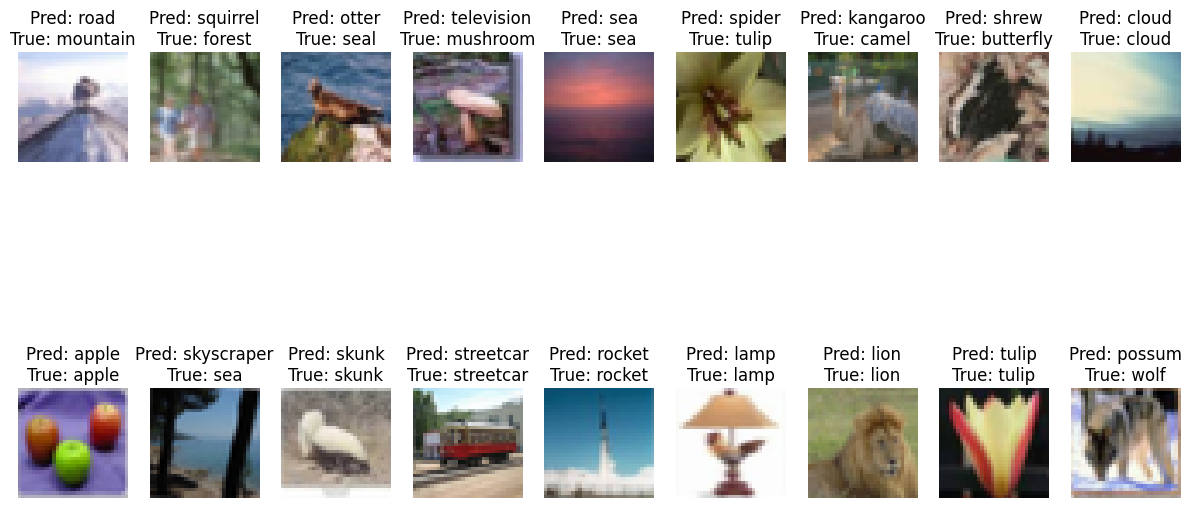

In [31]:
# Display some example predictions
def show_predictions(model, dataloader, class_names, num_images=8):
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(15, 8))
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                if images_so_far >= num_images:
                    return
                
                images_so_far += 1
                ax = plt.subplot(2, num_images//2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Pred: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')
                
                # Convert image for display
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                # Denormalize
                img = img * np.array(cifar100_std) + np.array(cifar100_mean)
                img = np.clip(img, 0, 1)
                
                plt.imshow(img)
    
    plt.tight_layout()
    plt.show()

# Show sample predictions
show_predictions(model, test_loader, class_names, num_images=18)